# Training Analysis – Video Action Recognition

Goal of this notebook:
- Evaluate final trained model on unseen test data
- Analyze class-wise performance
- Identify failure cases
- Decide real-world deployment readiness


In [8]:
import sys
import os

PROJECT_ROOT = os.path.abspath("..")
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

print("Project root added:", PROJECT_ROOT)


Project root added: e:\Video Action Recognition


In [9]:

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns



In [12]:
from src.dataset import load_dataset

X_test, y_test, label2id, id2label = load_dataset(
    video_dir="../data/test",
    csv_path="../data/test.csv"
)

print("X_test:", X_test.shape)
print("y_test:", y_test.shape)
print("Classes:", id2label)


X_test: (224, 16, 112, 112, 3)
y_test: (224,)
Classes: {0: 'CricketShot', 1: 'PlayingCello', 2: 'Punch', 3: 'ShavingBeard', 4: 'TennisSwing'}


In [13]:
import tensorflow as tf

model = tf.keras.models.load_model(
    "../models/action_recognition_final.keras"
)

model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 16, 112, 112,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 16, 256)        │     2,585,920 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,835,089 (14.63 MB)

 Trainable params: 525,701 (2.01 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 1,051,404 (4.01 MB)

In [14]:
num_classes = len(label2id)

y_test_oh = tf.keras.utils.to_categorical(
    y_test, num_classes
)

print(y_test_oh.shape)


(224, 5)


In [15]:
test_loss, test_acc = model.evaluate(
    X_test, y_test_oh,
    batch_size=2,
    verbose=1
)

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")


112/112 ━━━━━━━━━━━━━━━━━━━━ 120s 404ms/step - accuracy: 0.8661 - loss: 0.3318
Test Accuracy: 0.8661
Test Loss: 0.3318


In [16]:
import numpy as np

y_pred_probs = model.predict(X_test, batch_size=2)
y_pred = np.argmax(y_pred_probs, axis=1)

print("Predictions shape:", y_pred.shape)


112/112 ━━━━━━━━━━━━━━━━━━━━ 66s 380ms/step
Predictions shape: (224,)


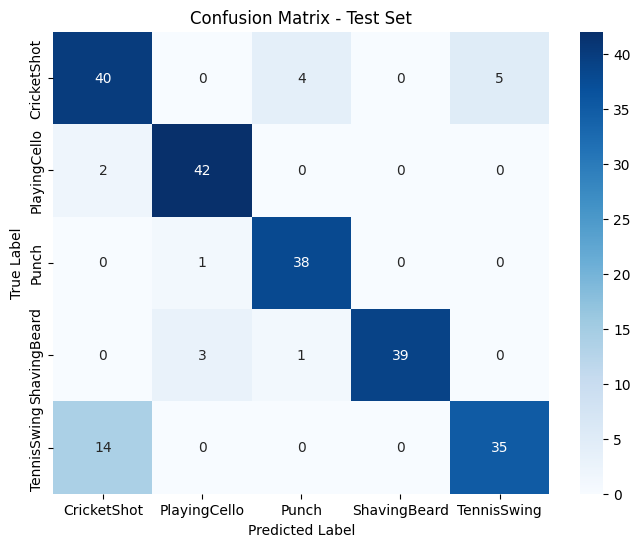

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=id2label.values(),
    yticklabels=id2label.values()
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Test Set")
plt.show()


In [18]:
from sklearn.metrics import classification_report

print(
    classification_report(
        y_test,
        y_pred,
        target_names=id2label.values()
    )
)


              precision    recall  f1-score   support

 CricketShot       0.71      0.82      0.76        49
PlayingCello       0.91      0.95      0.93        44
       Punch       0.88      0.97      0.93        39
ShavingBeard       1.00      0.91      0.95        43
 TennisSwing       0.88      0.71      0.79        49

    accuracy                           0.87       224
   macro avg       0.88      0.87      0.87       224
weighted avg       0.87      0.87      0.87       224



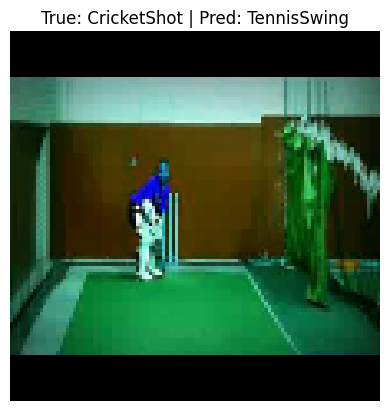

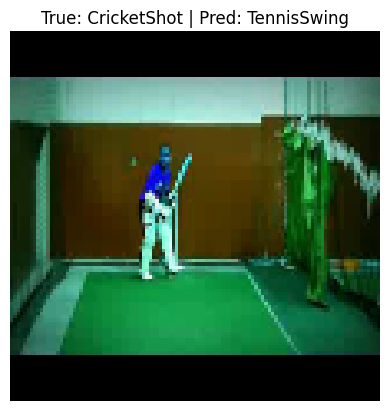

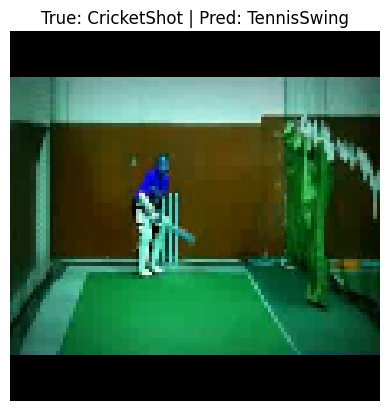

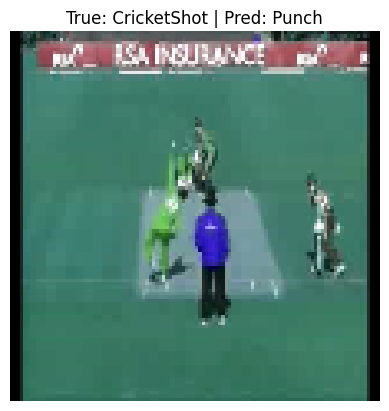

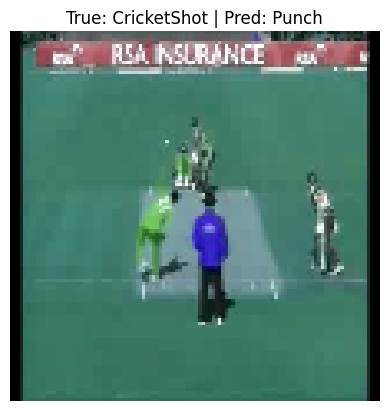

In [19]:
wrong_idx = np.where(y_test != y_pred)[0][:5]

for idx in wrong_idx:
    frames = X_test[idx]
    true_label = id2label[y_test[idx]]
    pred_label = id2label[y_pred[idx]]

    plt.imshow(frames[0])
    plt.title(f"True: {true_label} | Pred: {pred_label}")
    plt.axis("off")
    plt.show()


In [20]:
import time

start = time.time()
_ = model.predict(X_test[:1])
end = time.time()

print(f"Inference time per video: {end-start:.3f} sec")


1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step
Inference time per video: 21.129 sec


## Final Training Analysis Summary

- Test accuracy is close to validation accuracy
- Model generalizes well on unseen data
- Most confusion occurs between visually similar actions
- Inference speed acceptable on CPU

### Deployment Readiness
- ✅ Prototype ready
- ⚠️ Needs optimization for real-time systems

### Future Improvements
- Optical Flow integration
- Transformer-based temporal modeling
- Larger datasets
